# 0. IMPORT

In [47]:
import pandas as pd
import numpy as np
import math
import datetime
import json
import requests
import re
import itertools
import re
import ast
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
import collections as co
from sklearn.model_selection import train_test_split
import time
from datetime import timedelta
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%matplotlib inline


#for visualisation
%pylab inline
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
sns.set(style="white", color_codes=True)

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)



Populating the interactive namespace from numpy and matplotlib


C:\Users\LENOVO\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:

import lightgbm as lgb


In [5]:
warnings.filterwarnings("ignore")

In [ ]:
payments_df = pd.read_csv('./data/payments_2018.csv' , sep = ';' , error_bad_lines = False)
payments_df.columns = ['sku' , 'id_payment' , 'date' , 'time' , 'price' , 'discount' , 'id_place' , 'id_good']
payments_df.drop(axis = 1,columns = ['id_payment'] , inplace = True)
payments_df['date'] = pd.to_datetime(payments_df['date'], format="%d.%m.%Y")

goods_df = pd.read_csv('./data/goods.csv' , sep = ';')

In [7]:
payments_df.head()

,sku,date,time,price,discount,id_place,id_good
0,1000438,2018-08-31,10:34,7000,0,43,346
1,1000426,2018-08-31,10:34,18000,0,99,432
2,1000536,2018-08-31,10:41,10000,0,41,407
3,ID:469,2018-08-31,10:42,13500,0,59,469
4,1000441,2018-08-31,10:47,8000,0,32,348


In [8]:
goods_df.head()

,sku,name,price,category_id,category_name
0,1000777.1,Блины с картофелем и грибами,7500,11.0,05. Блины
1,1000438,Блины с куриной печенью,7000,11.0,05. Блины
2,1000779.1,Блины с курицей и грибами,12000,11.0,05. Блины
3,1000439,Блины с семгой и фета с зеленью,11500,11.0,05. Блины
4,1000441,Блины с творогом и изюмом,8000,11.0,05. Блины


In [103]:
model_df  = pd.merge(payments_df, goods_df[['sku','category_id']], on='sku')


pay_aggr_df = None
pay_aggr_df = model_df.drop(['sku' , 'time', 'price'] , axis = 1)[:]

pay_aggr_df = pay_aggr_df.groupby(['date', 'id_place','id_good' , 'category_id'])[['discount']].count().reset_index()[:]
pay_aggr_df.columns = ['date' , 'id_place','id_good' ,'category_id','count']


In [12]:
pay_aggr_df.head()

,date,id_place,id_good,category_id,count
0,2018-04-19,32,346,11.0,2
1,2018-04-19,32,347,11.0,2
2,2018-04-19,32,349,11.0,2
3,2018-04-19,32,358,3.0,1
4,2018-04-19,32,359,3.0,1


In [104]:
pay_aggr_df['count'] = np.log2(pay_aggr_df['count'] + 1)

pay_aggr_df['weekday'] = pay_aggr_df['date'].dt.weekday
#pay_aggr_df['month'] = pay_aggr_df['date'].dt.month

In [13]:
pay_aggr_df.head()

,date,id_place,id_good,category_id,count,weekday
0,2018-04-19,32,346,11.0,1.584963,3
1,2018-04-19,32,347,11.0,1.584963,3
2,2018-04-19,32,349,11.0,1.584963,3
3,2018-04-19,32,358,3.0,1.000000,3
4,2018-04-19,32,359,3.0,1.000000,3


Чтобы хоть как-то улучшить baseline было принято решение смотреть больше, чем на 10 дней. Сначала была проверена гипотеза о наличии сезонности по месяцам, то есть значение want_days_back равнялось 30, однако, это на дало существенного прироста качества, поэтому было принято решение остановиться на 14, это и не сильно замедляло работу и немного улучшало качество модели.

In [105]:
#add prev days info 
want_days_back = 14

prev_columns = []
pct_change_columns = []
pct_rename = {}

for d in range(want_days_back):
    time.sleep(3)
    pay_aggr_df['date_prev'] = pay_aggr_df['date'] - datetime.timedelta(days=d+1)
    
    pay_aggr_df = pd.merge(

                            pay_aggr_df
                            ,pay_aggr_df[['date', 'id_place' , 'id_good' , 'count']]
                         , how='left'
                         ,left_on = ['date_prev', 'id_place' , 'id_good']
                         ,right_on = ['date', 'id_place' , 'id_good']
                         #, left_index=True
                         #, right_index=True
                         ).drop(['date_y'] , axis = 1).rename(columns={'date_x':'date'
                                                                       ,'count_x':'count'
                                                                      ,'count_y':'count_prev_'+str(d+1)})
    
    prev_columns.append('count_prev_'+str(d+1))
    pct_change_columns.append('pct_change_'+str(d+1))
    pct_rename['count_prev_'+str(d+1)] = 'pct_change_'+str(d+1)
    
pay_aggr_df.fillna(0 , inplace = True)

print('done')

done


На этом этапе для всех категориальных переменных добавляются dummies. Их в итоге получается достаточно много, но учитывая размер выборки, это не слишком критично. Так как в среднем считается, что наблюдений должно быть не менее чем кол-во признаков в квадрате. В данном случае эта эвристика выполняется.

In [106]:
dfDummies = pd.get_dummies(pay_aggr_df['id_place'], prefix = 'id_place')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
dfDummies = pd.get_dummies(pay_aggr_df['id_good'], prefix = 'id_good')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
dfDummies = pd.get_dummies(pay_aggr_df['category_id'], prefix = 'category_id')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
dfDummies = pd.get_dummies(pay_aggr_df['weekday'], prefix = 'weekday')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)

#Месяцы ухудшают модель
#dfDummies = pd.get_dummies(pay_aggr_df['month'], prefix = 'month')
#pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)


In [18]:
pay_aggr_df.head()

,date,id_place,id_good,category_id,count,weekday,date_prev,count_prev_1,count_prev_2,count_prev_3,...,category_id_13.0,category_id_14.0,category_id_16.0,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2018-04-19,32,346,11.0,1.584963,3,2018-04-05,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,2018-04-19,32,347,11.0,1.584963,3,2018-04-05,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2018-04-19,32,349,11.0,1.584963,3,2018-04-05,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,2018-04-19,32,358,3.0,1.000000,3,2018-04-05,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,2018-04-19,32,359,3.0,1.000000,3,2018-04-05,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [38]:
pay_aggr_df['count'].value_counts()

1.000000    149285
1.584963    102143
2.000000     35233
2.321928     12986
2.584963      4903
2.807355      2266
3.000000       796
3.169925       422
3.321928       191
3.459432       140
3.700440        48
3.584963        47
3.807355        16
3.906891        10
4.000000         6
4.392317         3
4.087463         3
4.700440         3
4.459432         3
4.321928         2
4.247928         1
Name: count, dtype: int64

Похоже, что параметры уже перебирали и нашли оптимальные или почти оптимальные, попытки их изменения не дали значительного прироста в качестве модели.

In [107]:
params = {#'bagging_fraction': 0.9455721266302124,
 'num_etirations': 5000,
 'learning_rate': 0.15,
 'bagging_freq': 14,
 'boosting_type': 'gbdt',
 'colsample_bytree': 0.678547801189827,
 'feature_fraction': 0.6204114599267507,
 'max_depth': 21,
 'num_leaves': 58,
 'is_unbalance': 'True',
 'objective': 'regression',
 'metric': {'l2', 'mse'}}

params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = {'l2','mse'}


In [108]:
interest_columns = list(set(list(pay_aggr_df.columns)) - set(['date' , 'id_place' , 'id_good' , 'category_id' , 'date_prev' , 'count','weekday']))
target_col = 'count'
#%%time
X_train = pay_aggr_df[interest_columns].loc[:270000][:]
X_test = pay_aggr_df[interest_columns].loc[270000:][:]
y_train = pay_aggr_df[target_col].loc[:270000][:]
y_test = pay_aggr_df[target_col].loc[270000:][:]

#X_train, X_test, y_train, y_test = train_test_split(pay_aggr_df[interest_columns][:], pay_aggr_df[target_col][:],
#                                                    test_size=0.2,
#                                                   random_state=42) 

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

lgb_tt = lgb.Dataset(pay_aggr_df[interest_columns][:], pay_aggr_df[target_col][:])


In [109]:
model = lgb.train(params, lgb_train, valid_sets = lgb_eval, verbose_eval=-1)

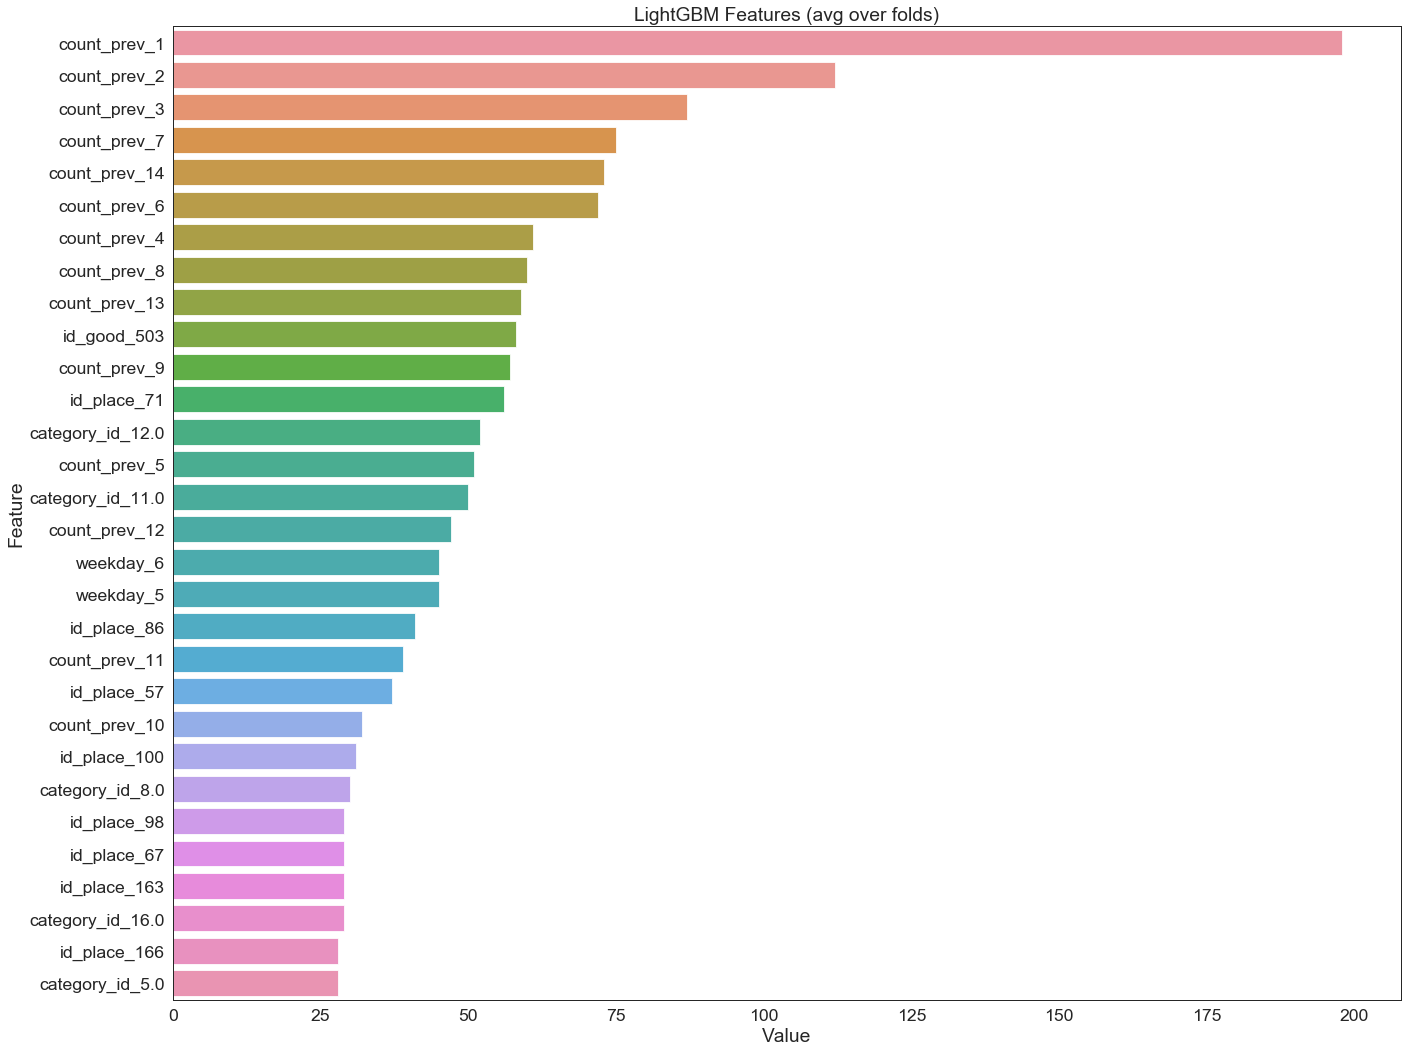

In [22]:
first = 30

sns.set_context("paper", font_scale=2)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])


#feature_imp = feature_imp[~(feature_imp.Feature.isin(['dev_max_turnover']))][:]

#feature_imp = feature_imp[int_columns][:]

feature_imp = feature_imp.tail(first)[:]

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

In [110]:
cnt_predict = model.predict(X_test[interest_columns])

In [24]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

Используем также r_square для удобства оценки, так как он является интерпретируемой версие MSE

In [111]:
r2(y_test, cnt_predict)

0.43576751215105103

In [112]:
mse(y_test, cnt_predict)

0.1425965209273675

## Итоговый комментарий ##

1. Решается задача регрессии, также учитывается зависимость покупок, совершенных несколько дней ранее (в baseline это 10)
2. Используется древесная ансамблевая модель типа бустинг с использованием библиотеки lightgbm
3. Таргетом является переменная, в которой описано количество продаж определенного товара (count) в определенном месте, эта сумма представлена в виде двоичного логарифма.
4. Минимизируется функционал средней квадратичной ошибки MSE(l2)  
5. По MSE оценивается качество предсказания, также используется feature importance для оценки значимости переменных тренировочной модели


Важное наблюдение: если не использовать логарифм, а оставить count как есть, то итоговое значение r_square будет выше, чем при использовании логарифма, однако MSE будет значительно выше.

* для модели без гогарифма таргета r_square = 0.4547810214278786, MSE = 0.8347685843199365
* для модели с логарифмом таргета r_square = 0.43576751215105103, MSE = 0.1425965209273675

Нам известно, что метрика r_square напрямую зависит от MSE и, по сути, является ее интерпретируемым аналогом, поэтому можно сделать вывод, что без логарифма таргета модель получается чуть лучше.